# Generate AnnData

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=120)

## Read in the raw data, annotations and segmentation information

### Counts

In [3]:
count_df = pd.read_csv('data/CN13_D2_unmodgtf_filtered_red_ut.tsv', sep='\t')
count_df.head()

,x,y,ensG,bc_old,bc,ensGV.x,count,ensGV.y,gene,spot_px_y,spot_px_x
0,472,292,ENSMUSG00000001175,472x292,472x292,ENSMUSG00000001175.13,1,ENSMUSG00000001175.14,Calm1,3088.455861,4857.79274
1,472,292,ENSMUSG00000001227,472x292,472x292,ENSMUSG00000001227.11,1,ENSMUSG00000001227.12,Sema6b,3088.455861,4857.79274
2,472,292,ENSMUSG00000001525,472x292,472x292,ENSMUSG00000001525.10,1,ENSMUSG00000001525.10,Tubb5,3088.455861,4857.79274
3,472,292,ENSMUSG00000014956,472x292,472x292,ENSMUSG00000014956.15,1,ENSMUSG00000014956.15,Ppp1cb,3088.455861,4857.79274
4,472,292,ENSMUSG00000022420,472x292,472x292,ENSMUSG00000022420.15,1,ENSMUSG00000022420.16,Dnal4,3088.455861,4857.79274


In [4]:
len(set(count_df.gene))

16175

### Segmentation 

In [5]:
segment_df = pd.read_csv('data/segmentation/CellID_Spot_Position_CN13_D2_filtered_red_ut.csv', sep=',')
segment_df['x'] = [int(x.split('x')[0]) for x in segment_df.bc]
segment_df['y'] = [int(x.split('x')[1]) for x in segment_df.bc]
segment_df.set_index('bc', inplace=True)
segment_df = segment_df[['x', 'y', 'cell_id']].rename(columns={'cell_id': 'segment_id'})
segment_df['segment_id'] = segment_df['segment_id'].astype(str)
segment_df.head()

,x,y,segment_id
bc,,,
472x292,472,292,32573
473x274,473,274,33616
473x280,473,280,33389
475x272,475,272,33886
475x273,475,273,33616


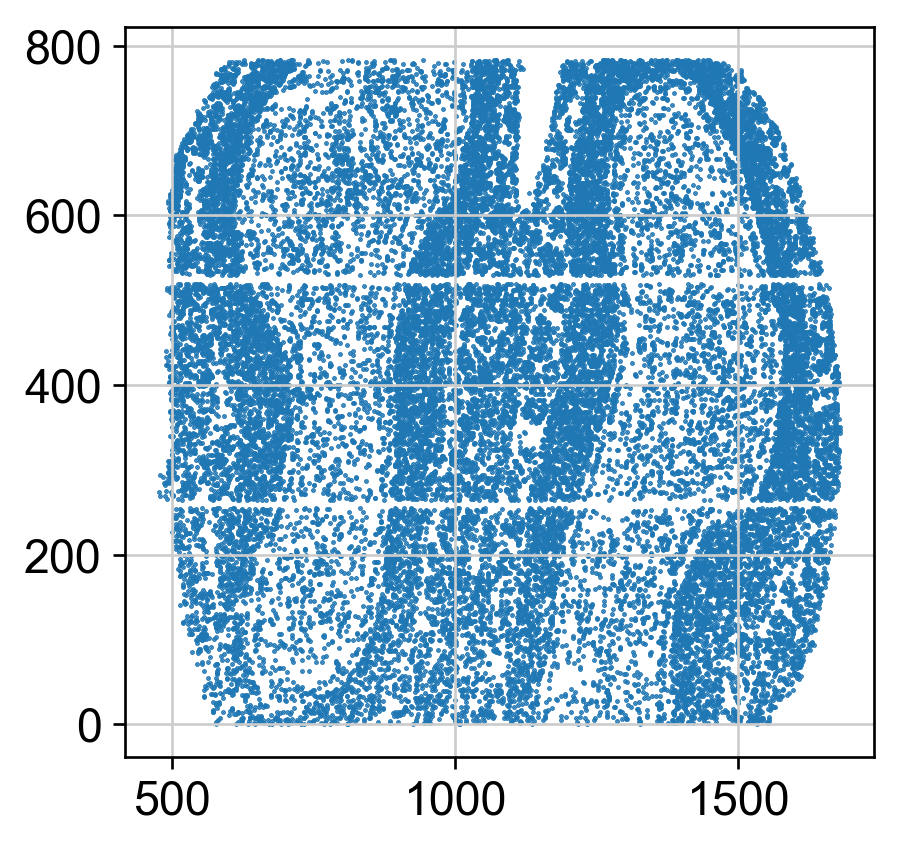

In [6]:
df = segment_df[segment_df.segment_id == '0'] # background
plt.scatter(df.x, df.y, s=0.2)

### Annotations

In [7]:
region_df = pd.read_csv('data/CN13_D2_barcodes_under_tissue_annot.tsv', sep='\t')
region_df.index = ['%sx%s' % (x, y) for x,y in zip(region_df.spot_x, region_df.spot_y)]
region_df.head()

,point.ID,spot_y,spot_x,spot_px_y,spot_px_x,poly.ID
568x1,1,1,568,943.676895,5674.670894,Olfactory Nerve Layer (ONL)
569x1,2,1,569,943.672988,5683.234835,Glomerular Layer (GL)
570x1,3,1,570,943.669082,5691.798775,Glomerular Layer (GL)
571x1,4,1,571,943.665175,5700.362715,Glomerular Layer (GL)
572x1,5,1,572,943.661269,5708.926656,Glomerular Layer (GL)


In [10]:
all_df = pd.merge(region_df, count_df, left_on=('spot_x', 'spot_y'), right_on=('x', 'y'), how='left')
all_df = pd.merge(all_df, segment_df, left_on=('spot_x', 'spot_y'), right_on=('x', 'y'), how='left')

In [11]:
all_df.head()

,point.ID,spot_y,spot_x,spot_px_y_x,spot_px_x_x,poly.ID,x_x,y_x,ensG,bc_old,bc,ensGV.x,count,ensGV.y,gene,spot_px_y_y,spot_px_x_y,x_y,y_y,segment_id
0,1,1,568,943.676895,5674.670894,Olfactory Nerve Layer (ONL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,569,943.672988,5683.234835,Glomerular Layer (GL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,570,943.669082,5691.798775,Glomerular Layer (GL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,571,943.665175,5700.362715,Glomerular Layer (GL),571.0,1.0,ENSMUSG00000015090,571x530,571x1,ENSMUSG00000015090.13,1.0,ENSMUSG00000015090.13,Ptgds,943.665175,5700.362715,571.0,1.0,48550
4,4,1,571,943.665175,5700.362715,Glomerular Layer (GL),571.0,1.0,ENSMUSG00000036103,571x530,571x1,ENSMUSG00000036103.8,1.0,ENSMUSG00000036103.8,Colec12,943.665175,5700.362715,571.0,1.0,48550


In [8]:
all_df.loc[all_df['count'].isnull(), 'count'] = 0.0

all_df.loc[all_df['ensG'].isnull(), 'ensG'] = 'ENSMUSG00000001227' #random gene as placeholders
all_df['ensG'] = all_df['ensG'].astype('category')

all_df.loc[all_df['gene'].isnull(), 'gene'] = 'Sema6b' #random gene as placeholders 
all_df['gene'] = all_df['gene'].astype('category')

all_df.loc[:, 'bc'] = ['%sx%s' % (a,b) for a,b in zip(all_df.loc[:, 'spot_x'], all_df.loc[:, 'spot_y'])]
all_df['bc'] = all_df['bc'].astype('category')

all_df.head()

,point.ID,spot_y,spot_x,spot_px_y_x,spot_px_x_x,poly.ID,x_x,y_x,ensG,bc_old,bc,ensGV.x,count,ensGV.y,gene,spot_px_y_y,spot_px_x_y,x_y,y_y,segment_id
0,1,1,568,943.676895,5674.670894,Olfactory Nerve Layer (ONL),NaN,NaN,ENSMUSG00000001227,NaN,568x1,NaN,0.0,NaN,Sema6b,NaN,NaN,NaN,NaN,NaN
1,2,1,569,943.672988,5683.234835,Glomerular Layer (GL),NaN,NaN,ENSMUSG00000001227,NaN,569x1,NaN,0.0,NaN,Sema6b,NaN,NaN,NaN,NaN,NaN
2,3,1,570,943.669082,5691.798775,Glomerular Layer (GL),NaN,NaN,ENSMUSG00000001227,NaN,570x1,NaN,0.0,NaN,Sema6b,NaN,NaN,NaN,NaN,NaN
3,4,1,571,943.665175,5700.362715,Glomerular Layer (GL),571.0,1.0,ENSMUSG00000015090,571x530,571x1,ENSMUSG00000015090.13,1.0,ENSMUSG00000015090.13,Ptgds,943.665175,5700.362715,571.0,1.0,48550
4,4,1,571,943.665175,5700.362715,Glomerular Layer (GL),571.0,1.0,ENSMUSG00000036103,571x530,571x1,ENSMUSG00000036103.8,1.0,ENSMUSG00000036103.8,Colec12,943.665175,5700.362715,571.0,1.0,48550


## Construct sparse tensors

In [9]:
def smooth_adata_groupwise(adata, layer_name, cat_name, sigma=1):
    
    from scipy import ndimage

    if sp.sparse.issparse(adata.X):
        adata.layers[layer_name] = adata.X.toarray()
    else:
        adata.layers[layer_name] = adata.X.copy()
    
    for group in tqdm_notebook(adata.obs[cat_name].cat.categories):
        idx = np.where(adata.obs[cat_name] == group)[0]

        for i, g in tqdm_notebook(list(enumerate(adata.var_names)), leave=False):
            img = sp.sparse.coo_matrix((adata[:, g].X[idx], (adata.obs.x[idx], adata.obs.y[idx]))).toarray()
            img2 = ndimage.gaussian_filter(img, sigma)
            img2 = (img2/img2.max()) * img.max() if img2.max() != 0 else img2
            adata.layers[layer_name][idx, i] = img2[adata.obs.x[idx], adata.obs.y[idx]]

    return adata

import sparse

sparse.COO(coords, data, shape=(5, 5))

In [9]:
(np.min(count_df.x.values), np.max(count_df.x.values)), (np.min(count_df.y.values), np.max(count_df.y.values))

((472, 1688), (1, 783))

In [10]:
(np.min(region_df.spot_x.values), np.max(region_df.spot_x.values)), (np.min(region_df.spot_y.values), np.max(region_df.spot_y.values))

((471, 1689), (1, 783))

In [11]:
len(region_df), len(count_df)

(874864, 356433)

## Scanpy AnnData

In [12]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

barcodes = CategoricalDtype(sorted(all_df.bc.unique()), ordered=True)
genes = CategoricalDtype(sorted(all_df.ensG.unique()), ordered=True)

row = all_df.bc.astype(barcodes).cat.codes
col = all_df.ensG.astype(genes).cat.codes
sparse_count_matrix = csr_matrix((all_df["count"], (row, col)), \
                                 shape=(barcodes.categories.size, 
                                        genes.categories.size))
sparse_count_matrix

<874864x16208 sparse matrix of type '<class 'numpy.float64'>'
	with 1112732 stored elements in Compressed Sparse Row format>

In [13]:
barcodes.categories.size, genes.categories.size

(874864, 16208)

In [14]:
# fraction of nonzeros
(sparse_count_matrix.nnz / np.prod(sparse_count_matrix.shape)) * 100.

0.007847306284238801

In [15]:
sparse_count_df = pd.SparseDataFrame(sparse_count_matrix, \
                                     index=barcodes.categories, \
                                     columns=genes.categories, \
                                     default_fill_value=0,
                                     dtype=int)
sparse_count_df.head()

,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000037,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000120,ENSMUSG00000000125,...,ENSMUSG00000110633,ENSMUSG00000110649,ENSMUSG00000110655,ENSMUSG00000110698,ENSMUSG00000110702,ENSMUSG00000110703,ENSMUSG00000110707,ENSMUSG00000110710,ENSMUSG00000110717,ENSMUSG00000110719
1000x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000x10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000x100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000x101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000x102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Import the sparse dataframe to Scanpy

In [16]:
adata = sc.AnnData(sparse_count_df.to_coo().tocsr())
adata.obs_names = sparse_count_df.index.values
adata.var_names = sparse_count_df.columns.values
adata

AnnData object with n_obs × n_vars = 874864 × 16208 

In [17]:
adata.obs.head()

""
1000x1
1000x10
1000x100
1000x101
1000x102


In [18]:
sum((adata.X.sum(0) == 0).A1)

0

## Add spatial coordinates, gene ids and region annotations

In [19]:
enstogene = count_df[['ensG', 'gene']].drop_duplicates()
enstogene.index = enstogene.ensG

# replace NA gene symbols with ensembl ids
nans = pd.isnull(enstogene.gene.values)
enstogene.gene[nans] = enstogene.ensG[nans]
enstogene.head()

,ensG,gene
ensG,,
ENSMUSG00000001175,ENSMUSG00000001175,Calm1
ENSMUSG00000001227,ENSMUSG00000001227,Sema6b
ENSMUSG00000001525,ENSMUSG00000001525,Tubb5
ENSMUSG00000014956,ENSMUSG00000014956,Ppp1cb
ENSMUSG00000022420,ENSMUSG00000022420,Dnal4


In [20]:
# Use negative coordinates as a workaround for the annoying difference in the interpretation of 0,0 point between spatial people and cartesian coords.
adata.obsm['X_spatial'] = np.vstack(([int(x.split('x')[0]) for x in adata.obs_names.values],
                                     [int(x.split('x')[1]) for x in adata.obs_names.values])).T
adata.var['gene_symbols'] = enstogene.gene
adata.var['gene_ids'] = enstogene.ensG
adata.obs['region'] = region_df['poly.ID']
adata.obs['segment'] = segment_df['segment_id']
adata.obs['segment'].fillna('0', inplace=True)

# replace gene symbols with ensembl IDs
adata.var_names = adata.var.gene_symbols.values
adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'

In [21]:
adata.var.head()

,gene_symbols,gene_ids
Gnai3,Gnai3,ENSMUSG00000000001
Cdc45,Cdc45,ENSMUSG00000000028
Scml2,Scml2,ENSMUSG00000000037
Narf,Narf,ENSMUSG00000000056
Cav2,Cav2,ENSMUSG00000000058


In [22]:
adata.obs.head()

,region,segment
1000x1,Olfactory Nerve Layer (ONL),0
1000x10,Olfactory Nerve Layer (ONL),0
1000x100,Olfactory Nerve Layer (ONL),0
1000x101,Olfactory Nerve Layer (ONL),0
1000x102,Olfactory Nerve Layer (ONL),0


In [23]:
adata.obsm['X_spatial']

array([[1000,    1],
       [1000,   10],
       [1000,  100],
       ...,
       [ 999,   97],
       [ 999,   98],
       [ 999,   99]])

... storing 'region' as categorical
... storing 'segment' as categorical


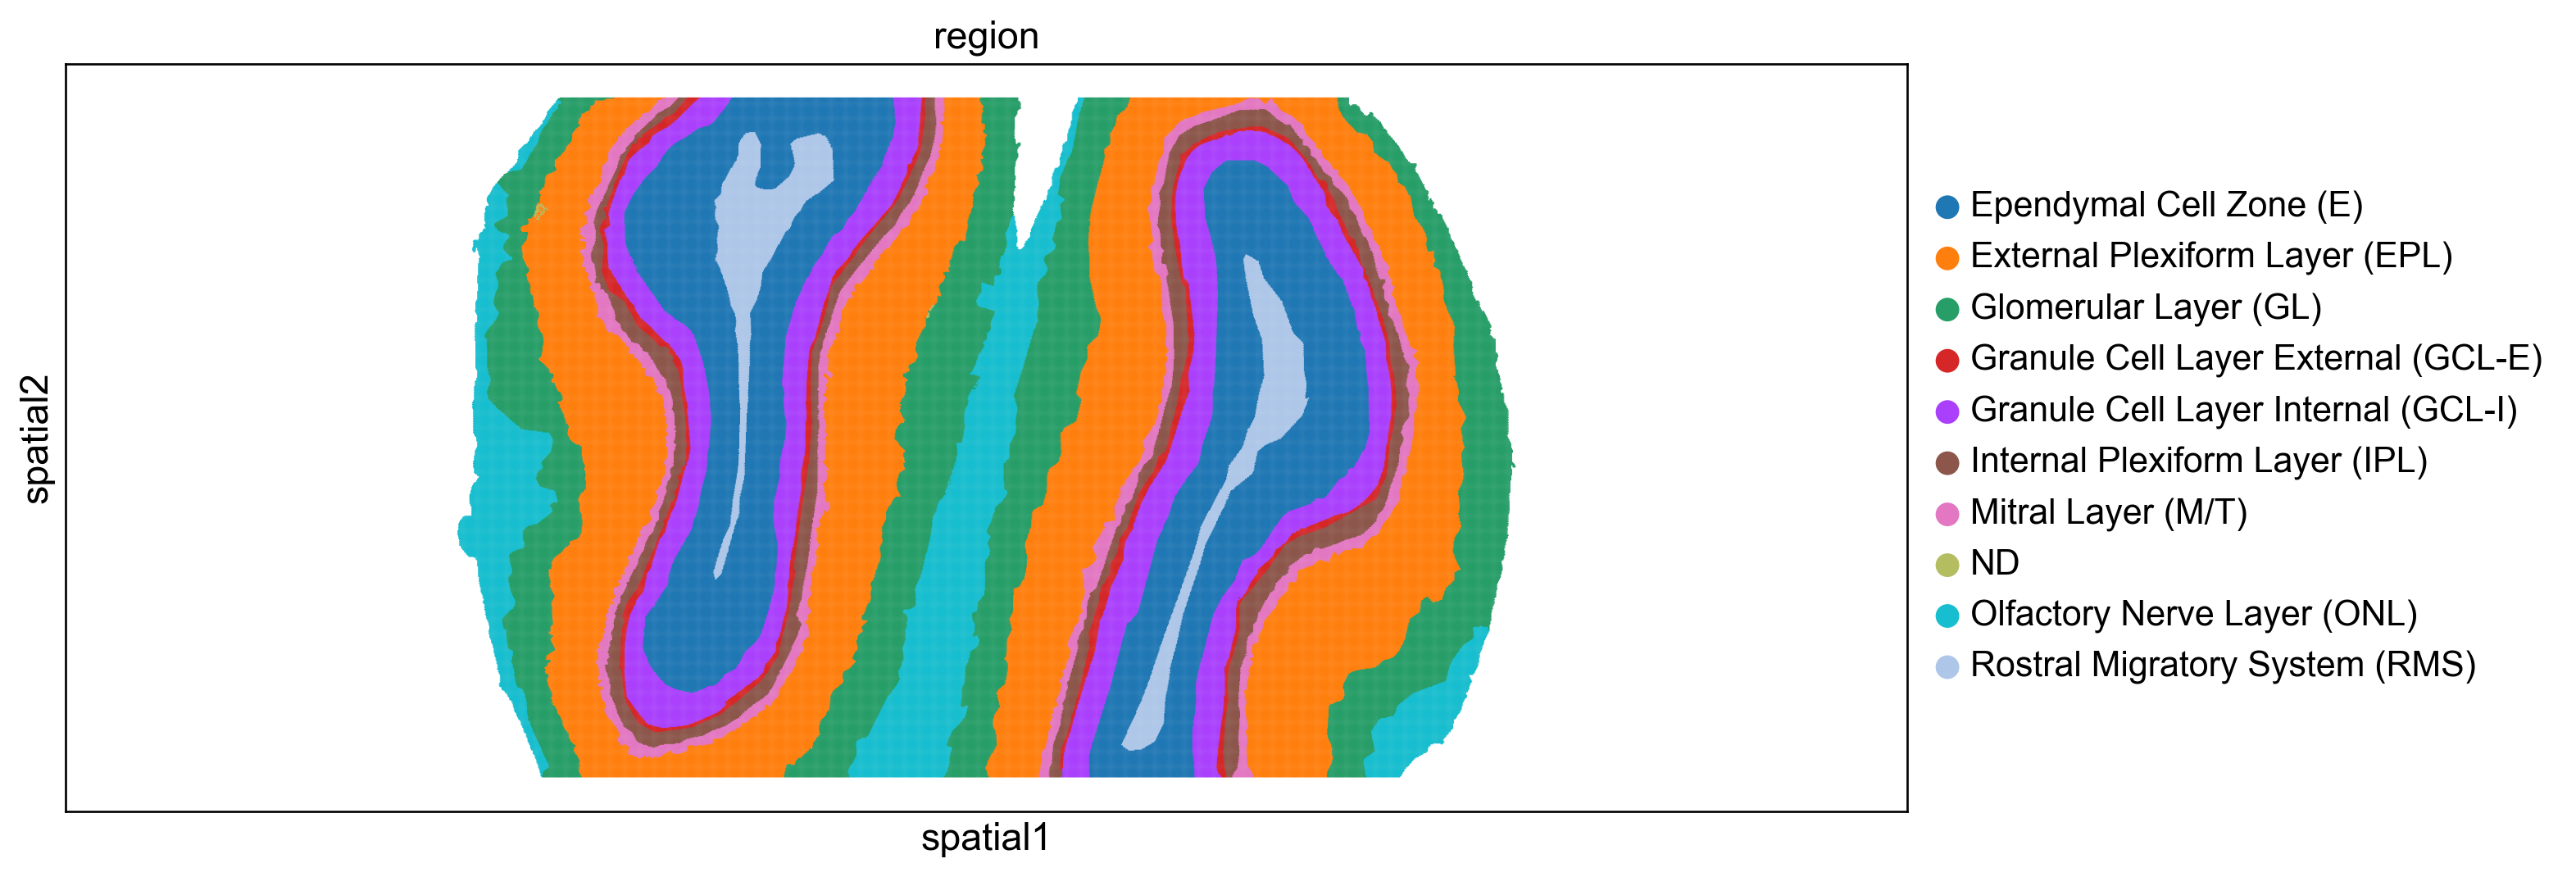

In [24]:
f, ax = plt.subplots(figsize=(12, 5))
sc.pl.scatter(adata, basis='spatial', color='region', size=1., ax=ax, show=False)
ax.axis('equal');

... storing 'region' as categorical
... storing 'segment' as categorical


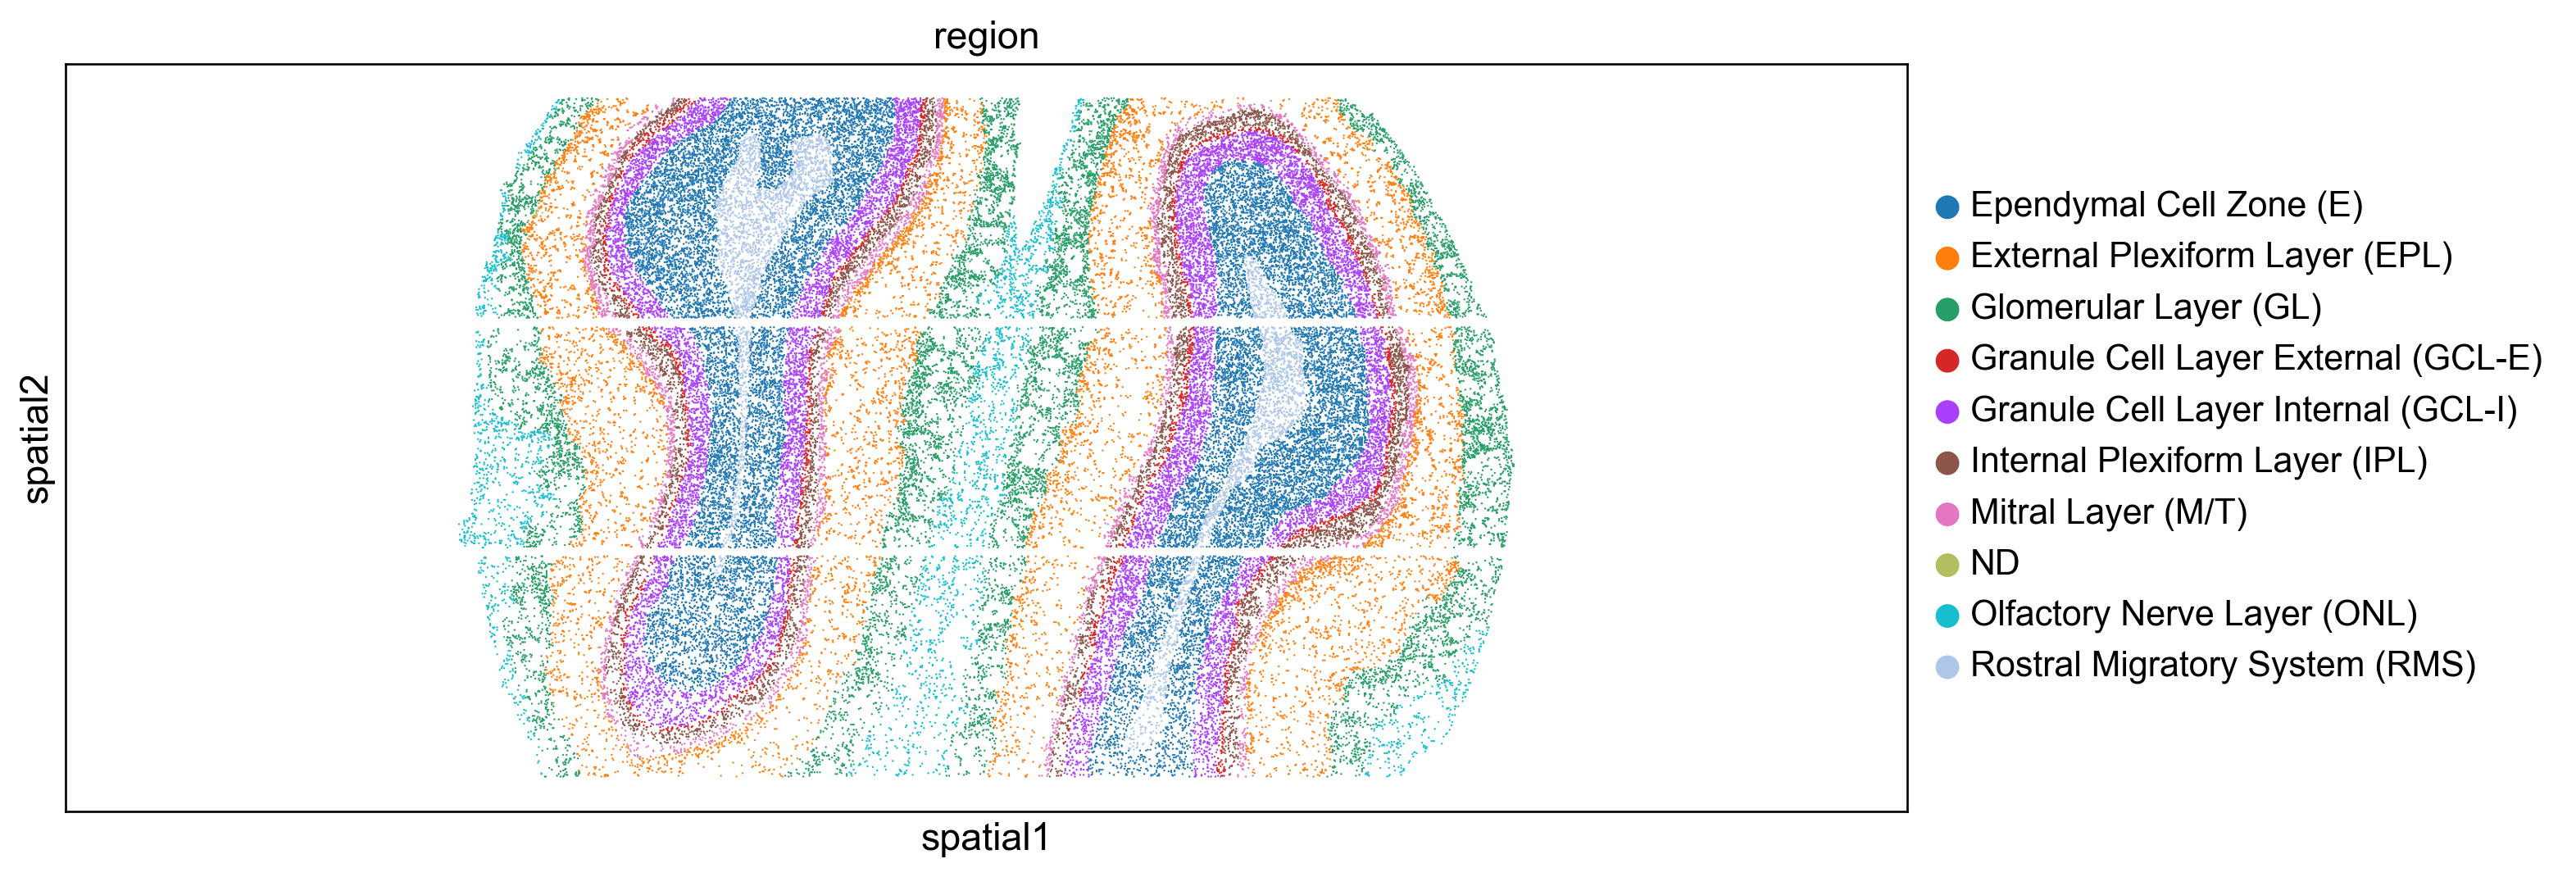

In [25]:
f, ax = plt.subplots(figsize=(12, 5))
sc.pl.scatter(adata[adata.obs.segment != '0'], basis='spatial', color='region', size=2., ax=ax, show=False)
ax.axis('equal');

In [26]:
adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [27]:
adata.obs.head()

,region,segment
1000x1,Olfactory Nerve Layer (ONL),0
1000x10,Olfactory Nerve Layer (ONL),0
1000x100,Olfactory Nerve Layer (ONL),0
1000x101,Olfactory Nerve Layer (ONL),0
1000x102,Olfactory Nerve Layer (ONL),0


In [28]:
sc.pp.filter_cells(adata, min_counts=1, copy=True)

AnnData object with n_obs × n_vars = 118565 × 16208 
    obs: 'region', 'segment', 'n_counts'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [29]:
sc.write('results/hdst.h5ad', adata)

... storing 'region' as categorical
... storing 'segment' as categorical
